# Check Tensorflow and GPU

In [1]:
import tensorflow as tf
print("GPU Available: ", tf.test.is_gpu_available())

print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
Tensorflow Version:  2.4.1
Keras Version:  2.4.0


In [2]:
#check GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Mon May  3 23:42:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |    349MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

If the GPU is not available, open Runtime -> Change runtime type and make sure that GPU is selected. Sometimes the GPU is still not available, you need to open Runtime -> reset all runtimes, then try again

# Tensorflow Regression (Low-level API)
ref: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/customization/custom_training.ipynb

Tensors in TensorFlow are immutable stateless objects. 
Machine learning models, however, must have changing state: as your model trains, the same code to compute predictions should behave differently over time. TensorFlow has stateful operations built-in, and these are often easier than using low-level Python representations for your state. Use tf.Variable to represent weights in a model. A tf.Variable object stores a value and implicitly reads from this stored value. There are operations (tf.assign_sub, tf.scatter_update, etc.) that manipulate the value stored in a TensorFlow variable. Computations using tf.Variable are automatically traced when computing gradients. For variables that represent embeddings, TensorFlow will do sparse updates by default, which are more computation and memory efficient.

In [5]:
v = tf.Variable(1.0)
# Use Python's `assert` as a debugging statement to test the condition
assert v.numpy() == 1.0

# Reassign the value `v`
v.assign(3.0)
assert v.numpy() == 3.0

# Use `v` in a TensorFlow `tf.square()` operation and reassign
v.assign(tf.square(v))
assert v.numpy() == 9.0

Let's use Tensor, Variable, and GradientTape—to build and train a simple model.

In [6]:
#Define the model
class Model(object):
  def __init__(self):
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be initialized to random values (for example, with `tf.random.normal`)
    self.W = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x): #nstances behave like functions and can be called like a function.
    return self.W * x + self.b

model = Model()

assert model(3.0).numpy() == 15.0

In [7]:
#Define an L2 loss,  mean square errors:
def loss(target_y, predicted_y): 
  return tf.reduce_mean(tf.square(target_y - predicted_y)) #https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean

In [8]:
#synthesize the training data by adding random Gaussian (Normal) noise to the inputs:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
noise   = tf.random.normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

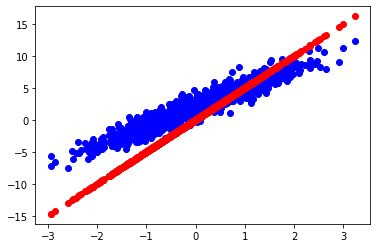

Current loss: 9.274932


In [9]:
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: %1.6f' % loss(model(inputs), outputs).numpy())

With the network and training data, train the model using gradient descent to update the weights variable (W) and the bias variable (b) to reduce the loss. There are many variants of the gradient descent scheme that are captured in tf.train.Optimizer—our recommended implementation. But in the spirit of building from first principles, here you will implement the basic math yourself with the help of tf.GradientTape for automatic differentiation and tf.assign_sub for decrementing a value (which combines tf.assign and tf.sub):

In [10]:
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(outputs, model(inputs))
  dW, db = t.gradient(current_loss, [model.W, model.b])
  model.W.assign_sub(learning_rate * dW)
  model.b.assign_sub(learning_rate * db)

Epoch  0: W=5.00 b=0.00, loss=9.27493
Epoch  1: W=4.58 b=0.41, loss=6.14660
Epoch  2: W=4.25 b=0.74, loss=4.19599
Epoch  3: W=3.98 b=1.00, loss=2.97962
Epoch  4: W=3.78 b=1.21, loss=2.22106
Epoch  5: W=3.62 b=1.37, loss=1.74795
Epoch  6: W=3.49 b=1.50, loss=1.45285
Epoch  7: W=3.39 b=1.61, loss=1.26877
Epoch  8: W=3.31 b=1.69, loss=1.15393
Epoch  9: W=3.25 b=1.75, loss=1.08228


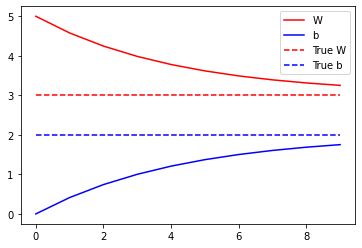

In [11]:
model = Model()

# Collect the history of W-values and b-values to plot later
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
  Ws.append(model.W.numpy())
  bs.append(model.b.numpy())
  current_loss = loss(outputs, model(inputs))

  train(model, inputs, outputs, learning_rate=0.1)
  print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss))

# Let's plot it all
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'True W', 'True b'])
plt.show()

# AUTO MPG Dataset

## Get the dataset
The Auto MPG dataset The dataset is available from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/

In [12]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

--2021-05-03 23:42:53--  http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30286 (30K) [application/x-httpd-php]
Saving to: ‘auto-mpg.data’

auto-mpg.data       100%[===================>]  29.58K  --.-KB/s    in 0.03s   

2021-05-03 23:42:53 (1.05 MB/s) - ‘auto-mpg.data’ saved [30286/30286]



In [13]:
!mv ./auto-mpg.data ./auto-mpg.csv

In [14]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [15]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
dataset_path = './auto-mpg.csv'
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
#names: array, List of column names to use, If the file contains a header row, then you should explicitly pass header=0 to override the column names
#sep: Delimiter to use, default ‘,’, ' ' in the original csv file
#na_values: Additional strings to recognize as NA/NaN, ? in the original csv file
#comment: str, Indicates remainder of line should not be parsed
#skipinitialspacebool, default False, Skip spaces after delimiter.
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [16]:
dataset.isna().sum() # hoursepower has 6 missing value 

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [17]:
dataset.count
dataset = dataset.dropna() #drop those rows.
dataset.count

<bound method DataFrame.count of       MPG  Cylinders  Displacement  ...  Acceleration  Model Year  Origin
0    18.0          8         307.0  ...          12.0          70       1
1    15.0          8         350.0  ...          11.5          70       1
2    18.0          8         318.0  ...          11.0          70       1
3    16.0          8         304.0  ...          12.0          70       1
4    17.0          8         302.0  ...          10.5          70       1
..    ...        ...           ...  ...           ...         ...     ...
393  27.0          4         140.0  ...          15.6          82       1
394  44.0          4          97.0  ...          24.6          82       2
395  32.0          4         135.0  ...          11.6          82       1
396  28.0          4         120.0  ...          18.6          82       1
397  31.0          4         119.0  ...          19.4          82       1

[392 rows x 8 columns]>

In [18]:
#The "Origin" column is categorical, not numeric. So convert that to a one-hot:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

In [19]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA


In [20]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')#Convert categorical variable into dummy/indicator variables.
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [21]:
print("dataset len: ", len(dataset))

dataset len:  392


In [22]:
#Split the data into train and test
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html
train_dataset = dataset.sample(frac=0.8,random_state=0)
print(train_dataset.index)
test_dataset = dataset.drop(train_dataset.index)

Int64Index([146, 282,  69, 378, 331, 257, 310, 328, 125, 108,
            ...
            171,  70, 307,  49, 209, 281, 229, 150, 145, 182],
           dtype='int64', length=314)


In [23]:
print("train dataset len: ", len(train_dataset))
print("test dataset len: ", len(test_dataset))

train dataset len:  314
test dataset len:  78


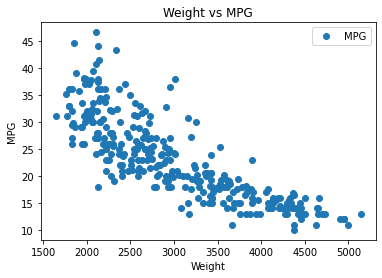

In [24]:
train_dataset.plot(x='Weight', y='MPG', style='o')
plt.title('Weight vs MPG')  
plt.xlabel('Weight')  
plt.ylabel('MPG')  
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


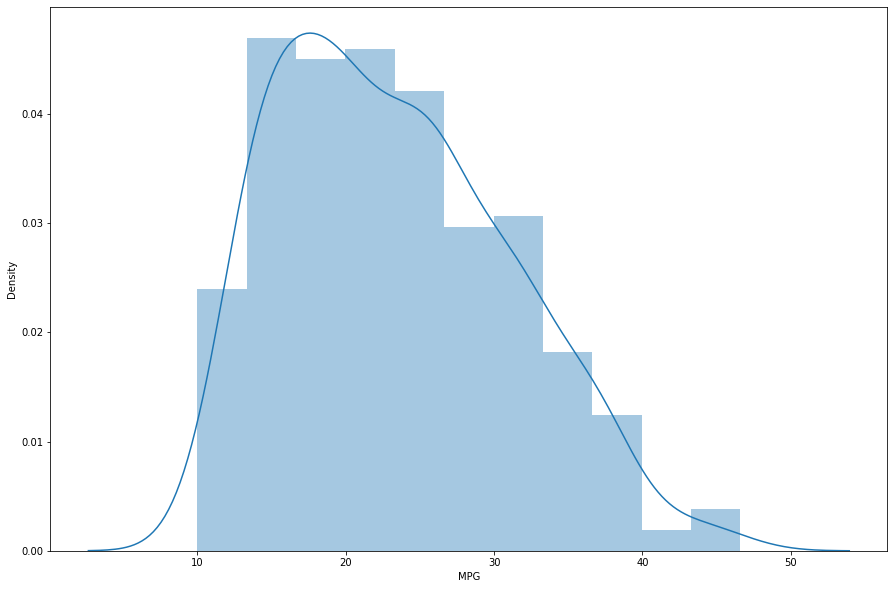

In [25]:
import seaborn as sns
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(train_dataset['MPG'])

In [26]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Neural Network
ref: https://www.tensorflow.org/tutorials/keras/regression

Split features from labels

In [27]:
train_labelsnew = train_dataset.pop('MPG')
test_labelsnew = test_dataset.pop('MPG')

Normalize the data

In [28]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Build the model

In [29]:
train_dataset.keys()

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'Europe', 'Japan', 'USA'],
      dtype='object')

Build the model
We'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [30]:
from tensorflow import keras
from tensorflow.keras import layers

In [31]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [32]:
model = build_model()

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of 10 examples from the training data and call model.predict on it.

In [34]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.10410526],
       [0.05047208],
       [0.6501118 ],
       [0.16020843],
       [0.04644988],
       [0.14852458],
       [0.01512074],
       [0.15039328],
       [0.07333438],
       [0.5282116 ]], dtype=float32)

In [35]:
normed_train_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,-0.465148,-0.495225,0.774676
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,-0.465148,-0.495225,0.774676
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,-0.465148,-0.495225,0.774676
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,-0.465148,-0.495225,0.774676
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-0.465148,2.012852,-1.286751
...,...,...,...,...,...,...,...,...,...
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,-0.465148,-0.495225,0.774676
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,-0.465148,-0.495225,0.774676
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-0.465148,2.012852,-1.286751
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-0.465148,2.012852,-1.286751


In [36]:
train_labelsnew

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

Train the model, Train the model for 1000 epochs, and record the training and validation accuracy in the history object.

In [37]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labelsnew,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/1000
8/8 [==============================] - 1s 62ms/step - loss: 580.7516 - mae: 22.8965 - mse: 580.7516 - val_loss: 537.9498 - val_mae: 21.8312 - val_mse: 537.9498
Epoch 2/1000
8/8 [==============================] - 0s 8ms/step - loss: 532.3161 - mae: 21.7024 - mse: 532.3161 - val_loss: 471.8087 - val_mae: 20.3649 - val_mse: 471.8087
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 459.7133 - mae: 20.1013 - mse: 459.7133 - val_loss: 400.1583 - val_mae: 18.6778 - val_mse: 400.1583
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 398.2846 - mae: 18.7348 - mse: 398.2846 - val_loss: 322.6259 - val_mae: 16.6811 - val_mse: 322.6259
Epoch 5/1000
8/8 [==============================] - 0s 7ms/step - loss: 325.2868 - mae: 16.6744 - mse: 325.2868 - val_loss: 246.6023 - val_mae: 14.4308 - val_mse: 246.6023
Epoch 6/1000
8/8 [==============================] - 0s 6ms/step - loss: 232.6602 - mae: 14.0637 - mse: 232.6602 - val_loss: 175.1378 - val_

In [38]:
#Visualize the model's training progress using the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.773235,1.098863,2.773235,9.155404,2.314805,9.155404,995
996,2.726493,1.111681,2.726493,9.346683,2.343444,9.346683,996
997,2.823575,1.065293,2.823575,8.672326,2.265336,8.672326,997
998,2.817318,1.053951,2.817318,8.826854,2.294214,8.826854,998
999,2.775087,1.061744,2.775087,8.719719,2.270829,8.719719,999


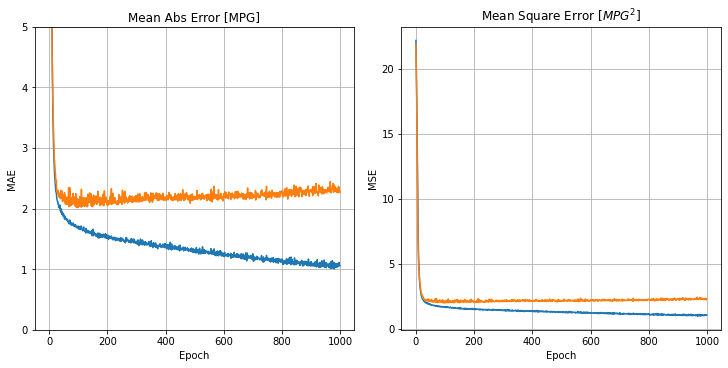

In [39]:

def plot_history(history, metric, val_metric):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  fig, (ax0, ax1) = plt.subplots(ncols=2, constrained_layout=True, figsize=(10,5))
  ax0.plot(hist['epoch'], hist[metric], label='Train Error')
  ax0.plot(hist['epoch'], hist[val_metric],label = 'Val Error')
  ax0.set_title('Mean Abs Error [MPG]')
  # ax0.set_yticks(yticks)
  # ax0.set_xticks(xticks)
  ax0.set_ylabel('MAE')
  ax0.set_xlabel('Epoch')
  ax0.grid(True)
  ax0.set_ylim([0,5])

  ax1.plot(hist['epoch'], hist[metric], label='Train Error')
  ax1.plot(hist['epoch'], hist[val_metric],label = 'Val Error')
  ax1.set_title('Mean Square Error [$MPG^2$]')
  ax1.grid(True)
  ax1.set_ylabel('MSE')
  ax1.set_xlabel('Epoch')

  plt.show()
  fig.savefig('trainhistory.pdf')

his1= history
plot_history(his1,'mae','val_mae')

## Neural Network2

In [40]:
# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 7.0MB/s 


In [41]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [42]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [43]:
def build_model1():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.03), activation=tf.nn.relu),
    #layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [44]:
model1 = build_model1()
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [45]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))


In [46]:
EPOCHS = 400
history = model1.fit(normed_train_data, train_labelsnew,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[CustomCallback()])
  #callbacks=[PrintDot()])

Starting training; got log keys: []
Start epoch 0 of training; got log keys: []
End epoch 0 of training; got log keys: ['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error']
Start epoch 1 of training; got log keys: []
End epoch 1 of training; got log keys: ['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error']
Start epoch 2 of training; got log keys: []
End epoch 2 of training; got log keys: ['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error']
Start epoch 3 of training; got log keys: []
End epoch 3 of training; got log keys: ['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error']
Start epoch 4 of training; got log keys: []
End epoch 4 of training; got log keys: ['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_me

In [47]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
395,5.604748,1.530080,4.910424,9.563270,2.246676,8.868816,395
396,5.579720,1.527393,4.886537,9.614120,2.208194,8.919328,396
397,5.430919,1.490995,4.737993,10.182780,2.333847,9.497950,397
398,5.765792,1.592757,5.073387,9.635791,2.309599,8.948530,398
399,5.620967,1.510201,4.930813,9.599264,2.224360,8.907869,399


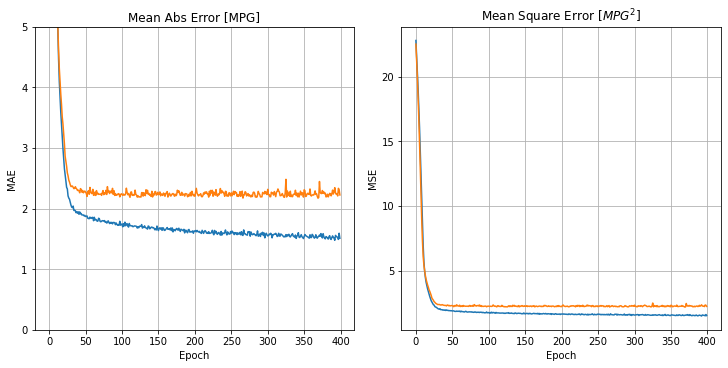

In [48]:
his2= history
plot_history(his2,'mean_absolute_error','val_mean_absolute_error')

In [49]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

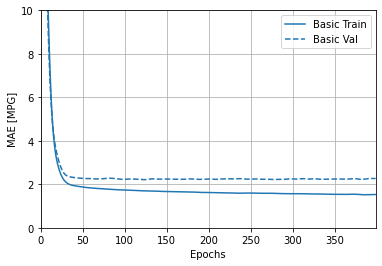

In [50]:
plotter.plot({'Basic': history}, metric = "mean_absolute_error")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

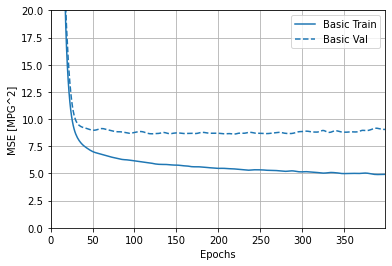

In [51]:
plotter.plot({'Basic': history}, metric = "mean_squared_error")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

EarlyStopping: We'll use an EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

In [52]:
model2 = build_model1()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model2.fit(normed_train_data, train_labelsnew, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:561.0045,  mean_absolute_error:22.4019,  mean_squared_error:559.0878,  val_loss:546.5630,  val_mean_absolute_error:22.1020,  val_mean_squared_error:544.6443,  
....................................................................................................
Epoch: 100, loss:7.6834,  mean_absolute_error:1.7450,  mean_squared_error:6.3422,  val_loss:9.1661,  val_mean_absolute_error:2.1730,  val_mean_squared_error:7.8380,  
.......................

Text(0, 0.5, 'MAE [MPG]')

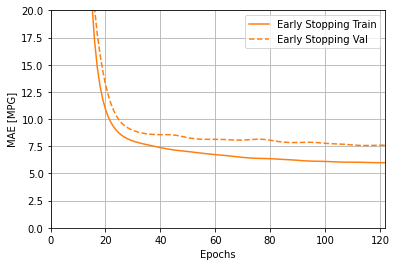

In [53]:
plotter.plot({'Early Stopping': early_history}, metric = "mean_squared_error")
plt.ylim([0, 20])
plt.ylabel('MAE [MPG]')

In [54]:
loss, mae, mse = model.evaluate(normed_test_data, test_labelsnew, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.4051 - mae: 1.9575 - mse: 6.4051
Testing set Mean Abs Error:  1.96 MPG


Make predictions

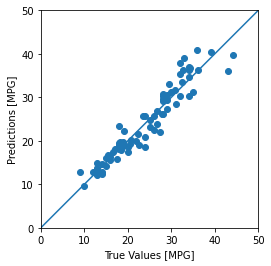

In [55]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labelsnew, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


error distribution

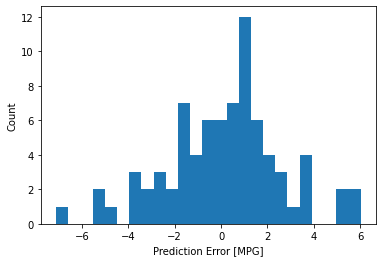

In [56]:
error = test_predictions - test_labelsnew
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [57]:
dfm = pd.DataFrame({'Actual': test_labelsnew, 'Predicted': test_predictions})
df1 = dfm.head(25)

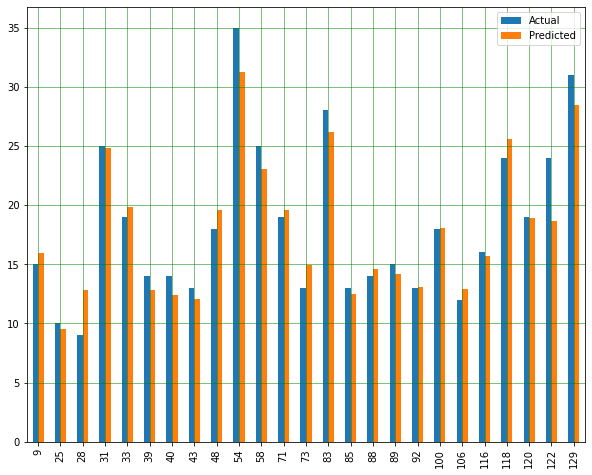

In [58]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Iris Dataset
https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/customization/custom_training_walkthrough.ipynb

In [59]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.4.1
Eager execution: True


The Iris classification problem
Imagine you are a botanist seeking an automated way to categorize each Iris flower you find. Machine learning provides many algorithms to classify flowers statistically. For instance, a sophisticated machine learning program could classify flowers based on photographs. Our ambitions are more modest—we're going to classify Iris flowers based on the length and width measurements of their sepals and petals.
The Iris genus entails about 300 species, but our program will only classify the following three:
Iris setosa, 
Iris virginica, 
Iris versicolor,

 
Fortunately, someone has already created a dataset of 120 Iris flowers with the sepal and petal measurements. This is a classic dataset that is popular for beginner machine learning classification problems.

Download the dataset

Download the training dataset file using the tf.keras.utils.get_file function. This returns the file path of the downloaded file:

In [60]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file: /root/.keras/datasets/iris_training.csv


In [61]:
train_dataset_fp

'/root/.keras/datasets/iris_training.csv'

In [62]:
!head -n5 {train_dataset_fp}
#The first line is a header containing information about the dataset: There are 120 total examples. Each example has four features and one of three possible label names.
#Subsequent rows are data records, one *example* per line, where: The first four fields are *features*: these are the characteristics of an example. Here, the fields hold float numbers representing flower measurements.
#The last column is the *label*: this is the value we want to predict. For this dataset, it's an integer value of 0, 1, or 2 that corresponds to a flower name.

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [63]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


Each label is associated with string name (for example, "setosa"), but machine learning typically relies on numeric values. The label numbers are mapped to a named representation, such as:
0: Iris setosa
1: Iris versicolor
2: Iris virginica

In [64]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

## Create a tf.data.Dataset

TensorFlow's Dataset API handles many common cases for loading data into a model. This is a high-level API for reading data and transforming it into a form used for training.
Since the dataset is a CSV-formatted text file, use the tf.data.experimental.make_csv_dataset function to parse the data into a suitable format. Since this function generates data for training models, the default behavior is to shuffle the data (shuffle=True, shuffle_buffer_size=10000), and repeat the dataset forever (num_epochs=None). We also set the batch_size parameter:

In [65]:
batch_size = 32

#The make_csv_dataset function returns a tf.data.Dataset of (features, label) pairs, where features is a dictionary: {'feature_name': value}
train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,#csv file path
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

In [66]:
features, labels = next(iter(train_dataset))
print("Features:", features)
print("Labels:", labels)

Features: OrderedDict([('sepal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([6.7, 5. , 5.1, 7.4, 6. , 4.6, 6.5, 5. , 6.4, 4.6, 5.5, 5.4, 6.6,
       5.8, 5.6, 5.4, 6.2, 5.7, 4.8, 5.8, 7.9, 6.3, 5.8, 5.9, 5.1, 6.3,
       5.1, 4.9, 4.6, 4.8, 6.6, 5. ], dtype=float32)>), ('sepal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([3.3, 2. , 3.5, 2.8, 2.9, 3.2, 3. , 2.3, 3.2, 3.1, 2.6, 3.4, 2.9,
       2.6, 2.9, 3. , 2.2, 2.8, 3.1, 4. , 3.8, 3.3, 2.8, 3.2, 3.8, 2.7,
       3.8, 3.1, 3.4, 3. , 3. , 3.6], dtype=float32)>), ('petal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([5.7, 3.5, 1.4, 6.1, 4.5, 1.4, 5.8, 3.3, 5.3, 1.5, 4.4, 1.5, 4.6,
       4. , 3.6, 4.5, 4.5, 4.5, 1.6, 1.2, 6.4, 4.7, 5.1, 4.8, 1.9, 4.9,
       1.5, 1.5, 1.4, 1.4, 4.4, 1.4], dtype=float32)>), ('petal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([2.1, 1. , 0.3, 1.9, 1.5, 0.2, 2.2, 1. , 2.3, 0.2, 1.2, 0.4, 1.3,
       1.2, 1.3, 1.5, 1.5, 1.3, 0.2, 0.2, 2. , 1.6,

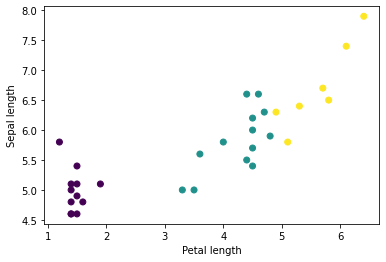

In [67]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

In [68]:
#To simplify the model building step, create a function to repackage the features dictionary into a single array with shape: (batch_size, num_features).
#This function uses the tf.stack method which takes values from a list of tensors and creates a combined tensor at the specified dimension:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

In [69]:
#Then use the tf.data.Dataset#map method to pack the features of each (features,label) pair into the training dataset:
train_dataset = train_dataset.map(pack_features_vector)

In [70]:
features, labels = next(iter(train_dataset))
print("Features:", features) #Features have been packed together
print("Labels:", labels)

Features: tf.Tensor(
[[5.1 3.7 1.5 0.4]
 [7.6 3.  6.6 2.1]
 [5.9 3.2 4.8 1.8]
 [5.  3.4 1.6 0.4]
 [6.  2.2 5.  1.5]
 [6.1 3.  4.9 1.8]
 [4.9 3.1 1.5 0.1]
 [6.9 3.1 4.9 1.5]
 [4.6 3.1 1.5 0.2]
 [5.5 2.6 4.4 1.2]
 [7.7 3.8 6.7 2.2]
 [4.7 3.2 1.3 0.2]
 [5.8 2.7 5.1 1.9]
 [4.9 3.1 1.5 0.1]
 [7.3 2.9 6.3 1.8]
 [6.3 3.4 5.6 2.4]
 [5.4 3.  4.5 1.5]
 [6.7 3.1 4.4 1.4]
 [5.7 3.8 1.7 0.3]
 [5.  3.2 1.2 0.2]
 [5.  3.5 1.6 0.6]
 [4.8 3.1 1.6 0.2]
 [5.2 2.7 3.9 1.4]
 [4.6 3.6 1.  0.2]
 [5.  2.3 3.3 1. ]
 [6.9 3.2 5.7 2.3]
 [4.6 3.2 1.4 0.2]
 [5.6 2.7 4.2 1.3]
 [6.5 3.  5.8 2.2]
 [5.5 2.4 3.8 1.1]
 [4.8 3.  1.4 0.3]
 [7.7 2.8 6.7 2. ]], shape=(32, 4), dtype=float32)
Labels: tf.Tensor([0 2 1 0 2 2 0 1 0 1 2 0 2 0 2 2 1 1 0 0 0 0 1 0 1 2 0 1 2 1 0 2], shape=(32,), dtype=int32)


In [71]:
#The features element of the Dataset are now arrays with shape (batch_size, num_features). Let's look at the first few examples:
features, labels = next(iter(train_dataset))
print(features[:5])

tf.Tensor(
[[4.9 3.1 1.5 0.1]
 [6.5 3.  5.2 2. ]
 [4.4 3.  1.3 0.2]
 [5.  3.  1.6 0.2]
 [6.4 2.8 5.6 2.2]], shape=(5, 4), dtype=float32)


##Create a model using Keras

In [72]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

In [73]:
predictions = model(features)#input one batch of features
predictions[:5]#each example returns a logit for each class.

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-1.743623  ,  0.8787148 ,  0.18211237],
       [-2.424905  ,  0.43756044,  0.15041266],
       [-1.6476691 ,  0.8321295 ,  0.15019235],
       [-1.782364  ,  0.8349054 ,  0.21274999],
       [-2.3506541 ,  0.3498932 ,  0.20621696]], dtype=float32)>

In [74]:
#To convert these logits to a probability for each class, use the softmax function:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.04623622, 0.6365744 , 0.31718934],
       [0.03160544, 0.5532416 , 0.41515297],
       [0.0526993 , 0.6291695 , 0.31813112],
       [0.04534878, 0.6211998 , 0.33345148],
       [0.03474239, 0.5172404 , 0.44801718]], dtype=float32)>

In [75]:
#Taking the tf.argmax across classes gives us the predicted class index. But, the model hasn't been trained yet, so these aren't good predictions:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
    Labels: [0 2 0 0 2 2 0 1 0 0 0 2 2 2 0 1 2 1 0 0 2 2 0 1 2 1 1 2 2 0 1 1]


## Create the model

Use tf.keras.losses.CategoricalCrossentropy: We expect labels to be provided in a one_hot representation
Use tf.keras.losses.SparseCategoricalCrossentropy: We expect labels to be provided as integers.

In [76]:
#https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
#Use this crossentropy loss function when there are two or more label classes. 
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#Whether y_pred is expected to be a logits tensor. By default, we assume that y_pred encodes a probability distribution. Default from_logits=False, 
#from_logits=True: Pushing the "softmax" activation into the cross-entropy loss layer significantly simplifies the loss computation and makes it more numerically stable.

In [77]:
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 1.7026147842407227


In [78]:
#Use the tf.GradientTape context to calculate the *gradients* used to optimize your model:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [79]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [80]:
#calculate a single optimization step:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 0, Initial Loss: 1.7026147842407227
Step: 1,         Loss: 1.5630648136138916


## Training loop

In [81]:
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.394, Accuracy: 45.000%
Epoch 050: Loss: 0.397, Accuracy: 91.667%
Epoch 100: Loss: 0.266, Accuracy: 96.667%
Epoch 150: Loss: 0.178, Accuracy: 98.333%
Epoch 200: Loss: 0.136, Accuracy: 97.500%


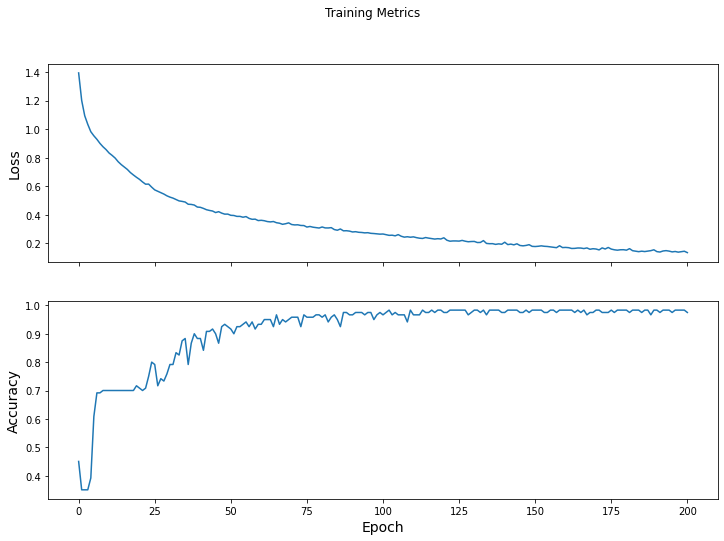

In [82]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## Get the test dataset

In [83]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [84]:
#Evaluate the model on the test dataset
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


In [85]:
prediction

<tf.Tensor: shape=(30,), dtype=int32, numpy=
array([1, 2, 0, 1, 1, 1, 0, 2, 1, 2, 2, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 1,
       2, 2, 1, 1, 0, 1, 2, 1], dtype=int32)>

In [86]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]], dtype=int32)>

In [87]:
#Use the trained model to make predictions
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

# training=False is needed only if there are layers with different
# behavior during training versus inference (e.g. Dropout).
predictions = model(predict_dataset, training=False)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (97.4%)
Example 1 prediction: Iris versicolor (86.2%)
Example 2 prediction: Iris virginica (84.9%)
